In [1]:
# Don't change this cell; just run it.
import numpy as np
import pandas as pd
from bootstrap_plots import *
from IPython.display import display, Markdown

# Safe settings for Pandas.
pd.set_option('mode.chained_assignment', 'raise')
%matplotlib inline
import matplotlib.pyplot as plt

# Make the plots look more fancy.
plt.style.use('fivethirtyeight')

# Confidence Intervals

- We will look at confidence intervals via a modern code-based method of generating them

- (I hope you'll agree!) this promotes a deep understanding of what confidence intervals convey

- The information the confidence intervals convey is the same as that conveyed by confidence intervals generated by "traditional" methods (e.g. those derived from formulas you have no doubt seen in statistics textbooks)

*Note*: This page has content from the [Bootstrap](https://github.com/data-8/textbook/blob/64b20f0/notebooks/Bootstrap.ipynb)
notebook of an older version of the [UC Berkeley data science course](https://inferentialthinking.com/). See the Berkeley course section of the [license file](https://uob-ds.github.io/cfd2021/license).


# The Fundamental Problem of Data Science

A data scientist is using the data in a random sample to estimate an unknown population parameter. She uses the sample to calculate the value of a statistic that she will use as her estimate.

Once she has calculated the observed value of her statistic, she could just present it as her estimate and go on her merry way. But she’s a data scientist. She knows that her random sample is just one of numerous possible random samples, and thus her estimate is just one of numerous plausible estimates.

She wants to know: by how much could those estimates vary - e.g. *how far could her estimate be from the population parameter*? To answer this, it appears as though she needs to draw many other samples from the population, and compute a new estimates based on the each new sample. This would give her a better estimate of the parameter. It would also tell her how much estimates of a sample of the size she took tend to deviate from the population parameter.

But she doesn’t have the resources to go back to the population and draw other samples.

It looks as though the data scientist is stuck with the sample she has, and knows that it is uncertain whether her sample gives a *good* estimate of the underlying population parameter.

This scenario illustrates what I will call "The Fundamental Problem" of data science:

> *What we care about are populations, but all we (usually!) have access to are samples.*

* Population - all the things (people, cars, rivers, planets) that we could measure a variable of interest for

* Sample - a subset of a population

More specifically: we care about populations and parameters but all we have access to are samples and statistics.

The problem we face with samples - even if they are randomly collected - is *sampling error* - on average, there will be some deviation of a sample statistic from the true population parameter.

We're going to use a real dataset now which puts us in the rare situation of
being able to view a entire population of datapoints.

This will allow us to view sampling error in real time: by drawing a random sample and comparing it to a known population parameter, to see how far off the sample estimate is.

## Employee Compensation in the City of San Francisco

[SF OpenData](https://data.sfgov.org) is a website where the City and County of
San Francisco make some of their data publicly available. One of the data sets
contains compensation data for employees of the City. These include medical
professionals at City-run hospitals, police officers, fire fighters,
transportation workers, elected officials, and all other employees of the City.

Compensation data for the calendar year 2015 are in the table `sf2015` below, for
all employees earning \\\$10,000 or more (equivalent to one year at half time hours).
The `Total Compensation` column shows employee's salary plus the City's contribution
towards his/her retirement and benefit plans.

In [2]:
# load in the data
sf2015 = pd.read_csv('san_francisco_2015.csv')

# show the first few rows
sf2015.head(20)

,Job,Total Compensation
0,Water Qualitytech I/II,117766.86
1,Soft Floor Coverer,41209.83
2,Health Care Billing Clerk 2,110561.13
3,Food Service Mgr Administrator,38624.97
4,Nurse Practitioner,260280.95
5,Transit Operator,111057.08
6,Attorney (Civil/Criminal),186781.38
7,Emp & Training Spec 2,103609.58
8,Transit Operator,116770.41
9,Police Officer,83708.17


There is one row for each of 36,569 employees. Here is the row
corresponding to the late [Mayor Ed
Lee](https://en.wikipedia.org/wiki/Ed_Lee_(politician))

In [3]:
# how many employees in the population?
len(sf2015)

36569

In [4]:
# get the row(s) corresponding to a specific job role
sf2015[sf2015['Job'] == 'Mayor']

,Job,Total Compensation
2868,Mayor,379798.03


## Population and Parameter

The 36,500 rows of the table above are our population. Let the population parameter
we are interested in be the the median `Total Compensation`.

Here is a histogram of the total compensations, along with the population parameter of interest:

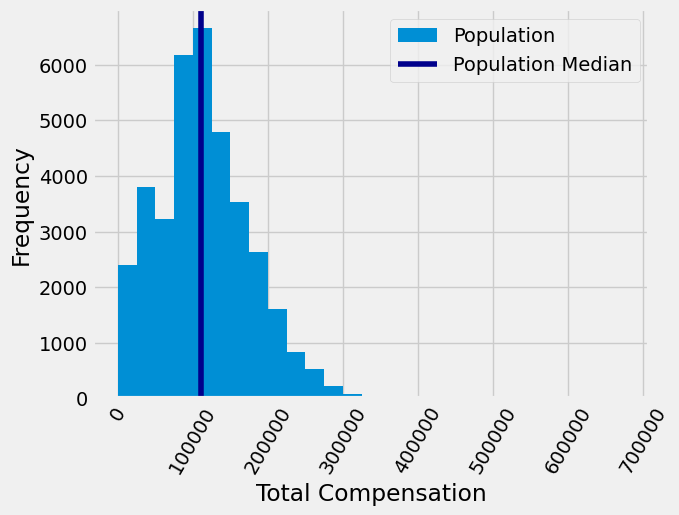

In [5]:
# set the bins for the histogram (this will allow us to see a bit more of the
# complexity of the distribution)
sf_bins = np.arange(0, 700000, 25000)

# plot the histogram
# plot the population data and show the median
population_plot_sf_data(sf2015, bins = sf_bins);

This is fairly typical for an income distribution - a lot of people have a little, a lot of people have some and a very small number of people have a lot...

While most of the values are below \\\$300,000, a few are quite a bit higher. For
example, the total compensation of the Chief Investment Officer was almost
\\\$650,000. That is why the horizontal axis stretches to \\\$700,000.

In [6]:
# show the data by Total Compensation, show highest earners at the top of the dataframe
sf2015.sort_values('Total Compensation', ascending=False).head()

,Job,Total Compensation
16306,Chief Investment Officer,648875.24
11244,Asst Med Examiner,480509.28
418,Asst Med Examiner,427219.28
15127,Dept Head V,426686.07
4428,"Adm, SFGH Medical Center",422799.94


Since we have the luxury of having all of the data from the population, we can
simply "look at" the parameter:

In [7]:
# isolate the population compensation values in a pandas Series
compensation = sf2015['Total Compensation']

# calculate the population median
pop_median = np.median(compensation)

# show the population median
print(f"The population median = {pop_median}")

The population median = 110305.79


The median total compensation of all employees was just over \$110,300.

## Sample and Statistic

[Link this back better to intro]

The situation were are typically in this: we have one sample giving us one estimate of a population parameter. But had the sample come out differently, the estimate would have had a different value. We would like to be
able to quantify the amount by which the estimate could vary across samples. That measure of variability will help us measure how accurately we can estimate the parameter.

In the current (luxury!) situation we [have access to whole population, can simulate the typical situation and see how far off our estimate is].

[Cell below shows how random samples are drawn from the table above]

In [8]:
# draw a random sample
sf2015.sample(15)

,Job,Total Compensation
32641,PS Aide To Prof,44659.20
20938,Licensed Vocational Nurse,161266.84
25149,Auto Svc Wrk Asst Sprv,129483.85
17514,Executive Secretary 1,25237.26
18095,Library Page,41368.94
5008,Water Qualitytech I/II,116669.46
138,Library Technical Assistant 2,114406.63
17159,Manager I,176040.36
13239,Recreation Coordinator,95683.61
7601,Engineer/Architect Principal,15811.16


[Cell below shows...]

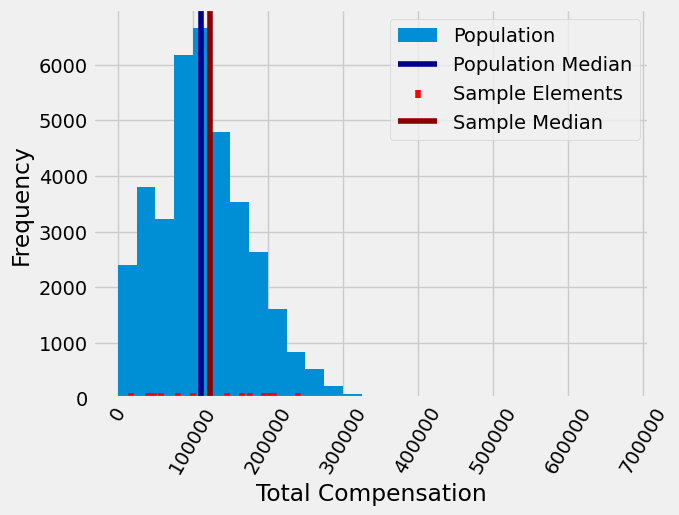

In [9]:
# draw a random sample, without replacement, from the population data
population_plot_sf_data_with_sample(sf2015, bins = sf_bins, sample_size = 15) 

# The Bootstrap

In the present situation - with access to an entire population's worth of data! - to see how different the estimate would be if the sample had come out differently, we can just draw another sample from the population, *but this
is cheating*. In real life typically we won't have all the population data at hand.

We will be stuck with one sample, trying to make inferences about an underlying population parameter.

Somehow, we have to get another random sample without sampling from the
population.

Fortunately, a brilliant idea called the bootstrap can help out here. The bootstrap let's us simulate drawing new random samples by a method called *resampling*: the new samples are drawn at random *from the original sample*.

*This may seem like a sleight of hand, but hopefully I can convince you it works!*

We will now see how and why the bootstrap works. 

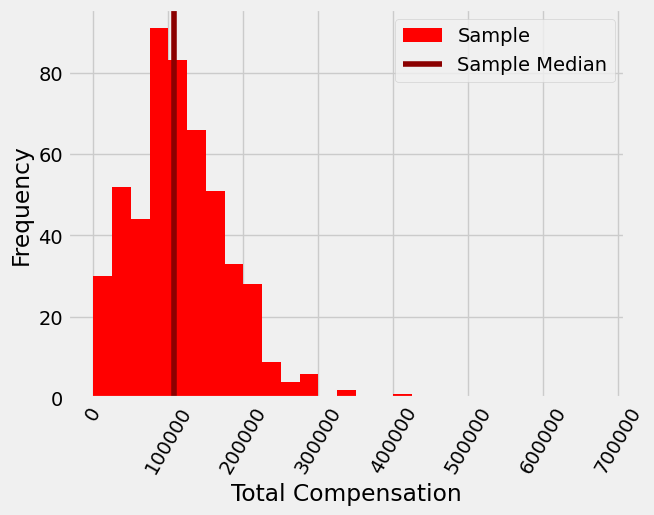

Sample Median = 107517

In [29]:
# draw a sample of size 500 from the compensation Series, without replacement.
our_sample = compensation.sample(500, replace=False)

# plot a histogram of the sample (and its median)
plot_our_sample(our_sample, sf_bins)

## The Bootstrap: Resampling from the Sample

What we do have is a large random sample from the population. As we know, a
large random sample is likely to resemble the population from which it is
drawn. This observation allows data scientists to *lift themselves up by their
own bootstraps*: the sampling procedure can be replicated by *sampling from the
sample*.

Here are the steps of *the bootstrap method* for generating another random
sample that resembles the population:

- **Treat the original sample as if it were the population.**
- **Draw from the sample**, at random **with** replacement, **a sample which is the same size as the original sample size**.

It is important to resample the same number of times as the original sample
size. The reason is that the variability of an estimate depends on the size of
the sample. Since our original sample consisted of 500 employees, our sample
median was based on 500 values. To see how different the sample could have
been, we have to compare it to the median of other samples of size 500.

#### Why do we resample WITH replacement?

If we drew 500 times at random *without* replacement from our sample of size
500, we would just get the same sample back. By drawing *with* replacement, we
create the possibility for the new samples to be different from the original,
because some employees might be drawn more than once and others not at all.

Why is this a good idea? By the law of averages, the distribution of the
original sample is likely to resemble the population, and the distributions of
all the "resamples" are likely to resemble the original sample. So the
distributions of all the resamples are likely to resemble the population as
well.

![](bootstrap_pic.png)

## A Resampled Median

Our `compensation` values are stored in a pandas Series. We will use the `sample` method of a pandas Series to take the new sample with replacement.

We want a sample the same size as the original sample (500), where we are
sampling *with replacement*.

Here is one new sample drawn from the original sample, with replacement, and
the corresponding sample median.

In [11]:
# draw a new sample
resample_1 = our_sample.sample(500, replace=True)

# show the sample
print(resample_1)

print(f"\n\nThe median of the current resample is {np.median(resample_1)}")

5079     251818.95
18040    118983.98
11506    119499.51
15040     31919.43
4118      45949.34
           ...    
1693     172137.74
27356    234655.11
944      162130.64
4576      72552.30
26624     84085.21
Name: Total Compensation, Length: 500, dtype: float64


The median of the current resample is 110623.17


578       43897.80
16755    111112.04
20166    140585.37
32923    104990.16
3500     128640.69
           ...    
13326     51047.32
22585    123865.92
3539      59647.94
15449     21024.90
4289     150566.33
Name: Total Compensation, Length: 500, dtype: float64


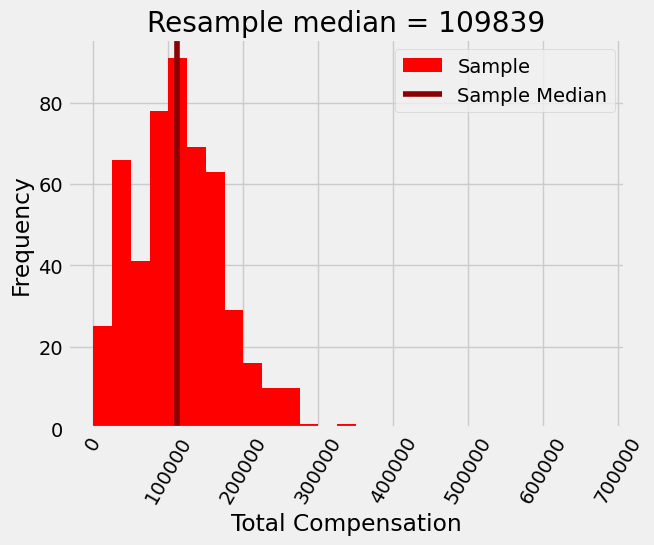

In [12]:
# draw a new sample
resample_1 = our_sample.sample(500, replace=True)

# show the sample
print(resample_1)

# plot the new sample
resample_1.plot.hist(bins=sf_bins, color = "red", label = "Sample")

# show the sample median
plt.axvline(np.median(our_sample), color = 'darkred', label = "Sample Median")

# calculate the median
resampled_median_1 = np.median(resample_1)
plt.title(f"Resample median = {int(np.round(resampled_median_1))}")

# show the legend, add x-axis labels
add_x_labels_total_compensation();

By resampling, we have something like another estimate of the population
median. By resampling again and again, we will get many such estimates, and
hence an empirical distribution of the estimates.  We can call this
distribution a *sampling distribution* of the median - it is the distribution
of the median values we get from taking many samples.  Our samples are
*bootstrap* samples, so this is the *bootstrap sampling distribution of the
median*.

In [13]:
resample_2 = our_sample.sample(500, replace=True)
resampled_median_2 = np.median(resample_2)
resampled_median_2

116669.46

## Bootstrap Empirical Distribution of the Sample Median

Let us define a function `bootstrap_median` that takes our original sample,
and the number of bootstrap samples we want to take, and returns an array of
the corresponding resampled medians.

Each time we resample and find the median, we *replicate* the bootstrap
process. So the number of bootstrap samples will be called the number of
replications.

In [14]:
def bootstrap_median(original_sample, replications):
    """Return array of bootstrapped sample medians

    Parameters
    ----------
    original_sample: Series
        Series containing the original sample
    replications: number
        number of bootstrap samples

    Returns
    -------
    samp_meds : array
        Array of bootstrapped sample medians.
    """
    # calculate the length of the original sample
    n = len(original_sample)
    
    # create an empty array to store the estimate of the medians
    # over repeated resamples
    medians = np.zeros(replications)

    # repeat the resampling procedure, and store the estimate of
    # the median each time
    for i in np.arange(replications):
        bootstrap_sample = original_sample.sample(n, replace=True)
        medians[i] = np.median(bootstrap_sample)
        
    # return the array of estimate medians
    return medians

We now replicate the bootstrap process 5,000 times. The array `bstrap_medians`
contains the medians of all 5,000 bootstrap samples. Notice that the code
takes longer to run than our previous code. It has a lot of resampling to do!

In [15]:
# run our function, to generate an array containing the bootstrapped medians
bstrap_medians = bootstrap_median(our_sample, 5000)

# show the array
bstrap_medians

array([110192.96 , 113757.16 , 116237.405, ..., 114065.175, 111851.015,
       110192.96 ])

Here is the histogram of the 5000 medians. The blue line is the population
parameter: it is the median of the entire population, which we happen to know
but did not use in the bootstrap process.

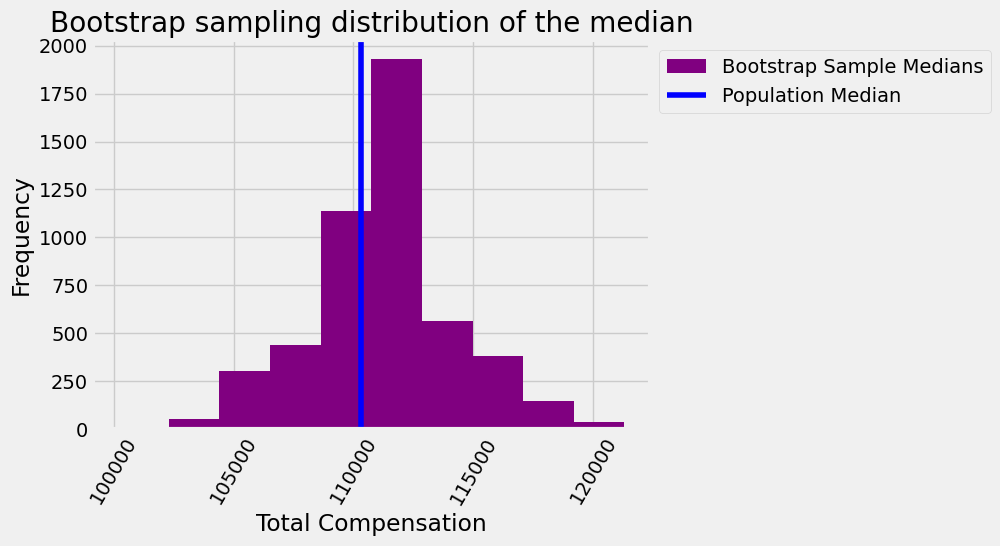

In [16]:
# a new dataframe for the medians, obtained via resampling
resampled_medians = pd.DataFrame()
resampled_medians['Bootstrap Sample Medians'] = bstrap_medians

# plot the distribution of bootstrapped medians
resampled_medians.plot.hist(color = 'purple')

# show the population median
plt.axvline(pop_median,  color='blue', label = 'Population Median')

# add title and labels to the plot
plt.title('Bootstrap sampling distribution of the median')
add_x_labels_total_compensation();

It is important to remember that the blue line is fixed: it is \\\$110,305.79, the
population median. The empirical histogram is the result of random draws, and
will be situated randomly relative to the blue line.

Remember also that the point of all these computations is to estimate the
population median, which is the blue line. Our estimates are all the randomly
generated sampled medians whose histogram you see above. We want those
estimates to contain the parameter – it they don't, then they are off.


## Do the Estimates Capture the Parameter?

How often does the empirical histogram of the resampled medians sit firmly over
the blue line, and not just brush the linewith its tails? To answer this, we must
define "sit firmly". Let's take that to mean "the middle 95% of the resampled
medians contains the blue line".

Here are the two ends of the "middle 95%" interval of resampled medians:

In [17]:
# calculate the 2.5 percentile of the bootstrapped medians
left = np.percentile(bstrap_medians, 2.5)
left

105034.5

In [18]:
# calculate the 97.5 percentile of the bootstrapped medians
right = np.percentile(bstrap_medians, 97.5)
right

117414.07

In fact we can get both left and right percentiles in one call, like this:

In [19]:
# get both the percentiles in an array
np.percentile(bstrap_medians, [2.5, 97.5])

array([105034.5 , 117414.07])

We can use unpacking in the usual way, to set our `left` and `right` variables:

In [20]:
left, right = np.percentile(bstrap_medians, [2.5, 97.5])
print('Left:', left)
print('Right:', right)

Left: 105034.5
Right: 117414.07


The population median of \$110,305 is between these two numbers, `left` and
`right`. We show the interval and the population median on the histogram below.

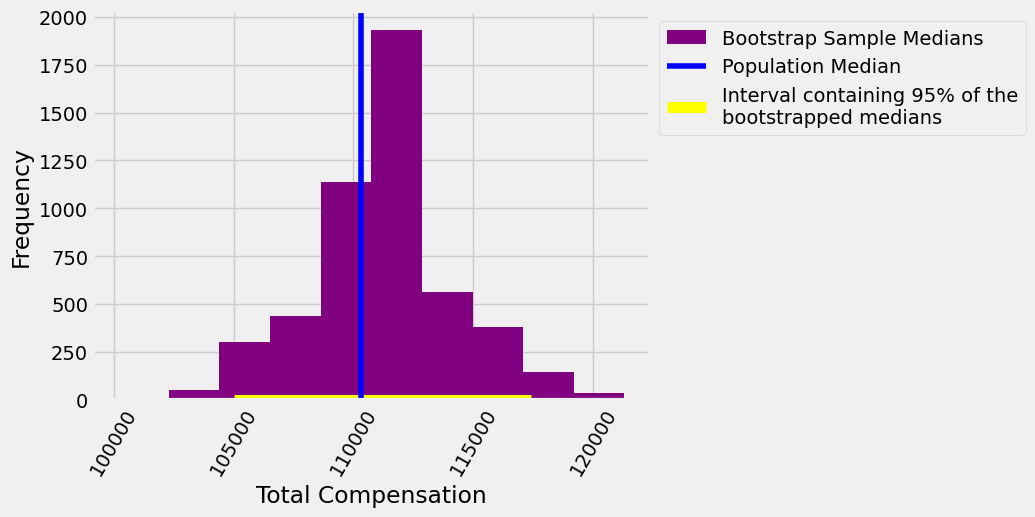

In [21]:
resampled_medians.plot.hist(color = 'purple')
plt.axvline(pop_median,  color='blue', label = 'Population Median')
plt.plot([left, right], [0, 0], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nbootstrapped medians")
add_x_labels_total_compensation();

The "middle 95%" interval of estimates captured the parameter in our example.
But was that a fluke?

To see how frequently the interval contains the parameter, we have to run the
entire process over and over again. Specifically, we will repeat the following
process 100 times:

* Draw an original sample of size 500 from the population.
* Carry out 5,000 replications of the bootstrap process and generate the
  "middle 95%" interval of resampled medians.

As usual we start by doing one trial, where we take one sample, and generate
one left and one right interval.  This is the code we have been using above.

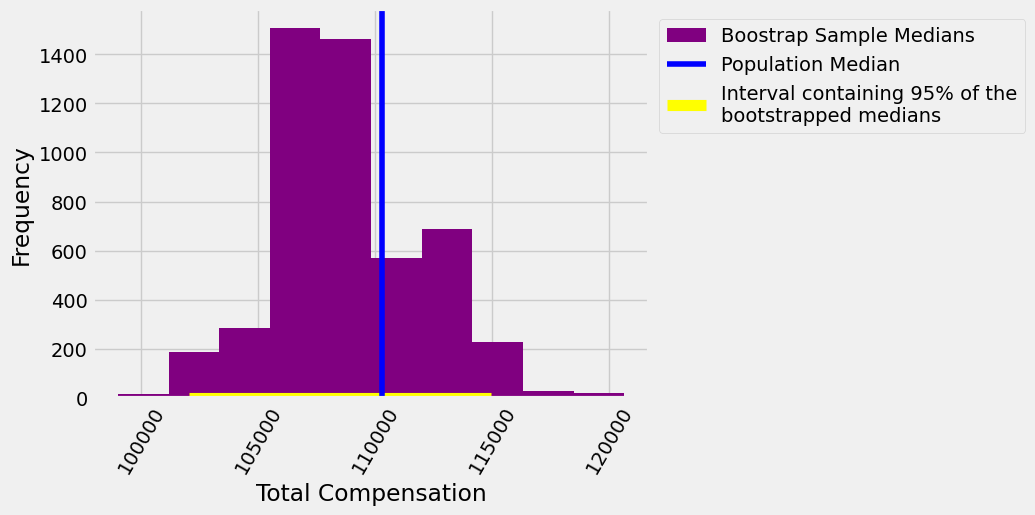

Left 102062.26999999999
Left 114947.065


In [22]:
# One trial, generating a left and right interval.
# Take a new sample.
this_sample = compensation.sample(500, replace=True)
# Get the bootstrap sampling distribution of the median.
these_medians = pd.Series(bootstrap_median(this_sample, 5000))

these_medians.plot.hist(color = 'purple', label = "Boostrap Sample Medians")
plt.axvline(pop_median,  color='blue', label = 'Population Median')

# Calculate the left, right ends, and plot them.
left_end, right_end = np.percentile(these_medians, [2.5, 97.5])
plt.plot([left_end, right_end], [0, 0], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nbootstrapped medians")

# add plot labels
add_x_labels_total_compensation()
plt.show()

# show the left and right end values
print('Left', left_end)
print('Left', right_end)

We will repeat this trial procedure 20 times, to give with 20 left and right
intervals, and count how many of these intervals contain the population median.

**Spoiler alert:** The statistical theory of the bootstrap says that the number
should be around 95. It may be in the low 90s or high 90s, but not much farther
off 95 than that.

In [23]:
# THE BIG SIMULATION: This one can take several minutes.

# Set up to make 20 left and right intervals
n_intervals = 20
left_ends = np.zeros(n_intervals)
right_ends = np.zeros(n_intervals)

for i in np.arange(n_intervals):
    # One trial, generating a left and right interval.
    # Take a new sample.
    this_sample = compensation.sample(500, replace=True)
    # Get the bootstrap sampling distribution of the median.
    these_medians = bootstrap_median(this_sample, 5000)
    # Calculate the left, right ends.
    left_end, right_end = np.percentile(these_medians, [2.5, 97.5])
    # Store the results for this trial.
    left_ends[i] = left_end
    right_ends[i] = right_end

# Put interval ends into own data frame.
intervals = pd.DataFrame()
intervals['Left'] = left_ends
intervals['Right'] = right_ends

For each of the 25 replications, we get one (left, right) interval of
estimates of the median.

In [24]:
intervals

,Left,Right
0,102258.644125,113371.13000
1,102374.895000,116629.72500
2,108877.455000,117478.80525
3,100904.210000,112225.56000
4,105286.730000,118430.92500
5,103334.145000,116465.67500
6,101177.754625,114147.39500
7,107356.985000,117631.12500
8,104000.805000,115440.38000
9,102966.800000,111447.65000


The good intervals are those that contain the parameter we are trying to
estimate. Typically the parameter is unknown, but in this section we happen to
know what the parameter is.

In [25]:
pop_median

110305.79

How many of the 20 intervals contain the population median? That's the number
of intervals where the left end is below the population median and the right
end is above.

In [26]:
intervals["Contains Population Median"] = np.logical_and(left_ends < pop_median, right_ends > pop_median)
intervals

,Left,Right,Contains Population Median
0,102258.644125,113371.13000,True
1,102374.895000,116629.72500,True
2,108877.455000,117478.80525,True
3,100904.210000,112225.56000,True
4,105286.730000,118430.92500,True
5,103334.145000,116465.67500,True
6,101177.754625,114147.39500,True
7,107356.985000,117631.12500,True
8,104000.805000,115440.38000,True
9,102966.800000,111447.65000,True


It takes a few minutes to construct all the intervals, but try it again if you
have the patience. Most likely, about 95% intervals will be good
ones: they will contain the parameter.

It's hard to show you all the intervals on the horizontal axis as they have
large overlaps – after all, they are all trying to estimate the same parameter.
The graphic below shows each interval on the same axes by stacking them
vertically. The vertical axis is simply the number of the replication from
which the interval was generated.

The red line is where the parameter is. Good intervals cover the parameter;
there are about 95 of these, typically.

If an interval doesn't cover the parameter, it's a dud. The duds are the ones
where you can see "daylight" around the red line. There are very few of them –
about 5, typically – but they do happen.

Any method based on sampling has the possibility of being off. The beauty of
methods based on random sampling is that we can quantify how often they are
likely to be off.

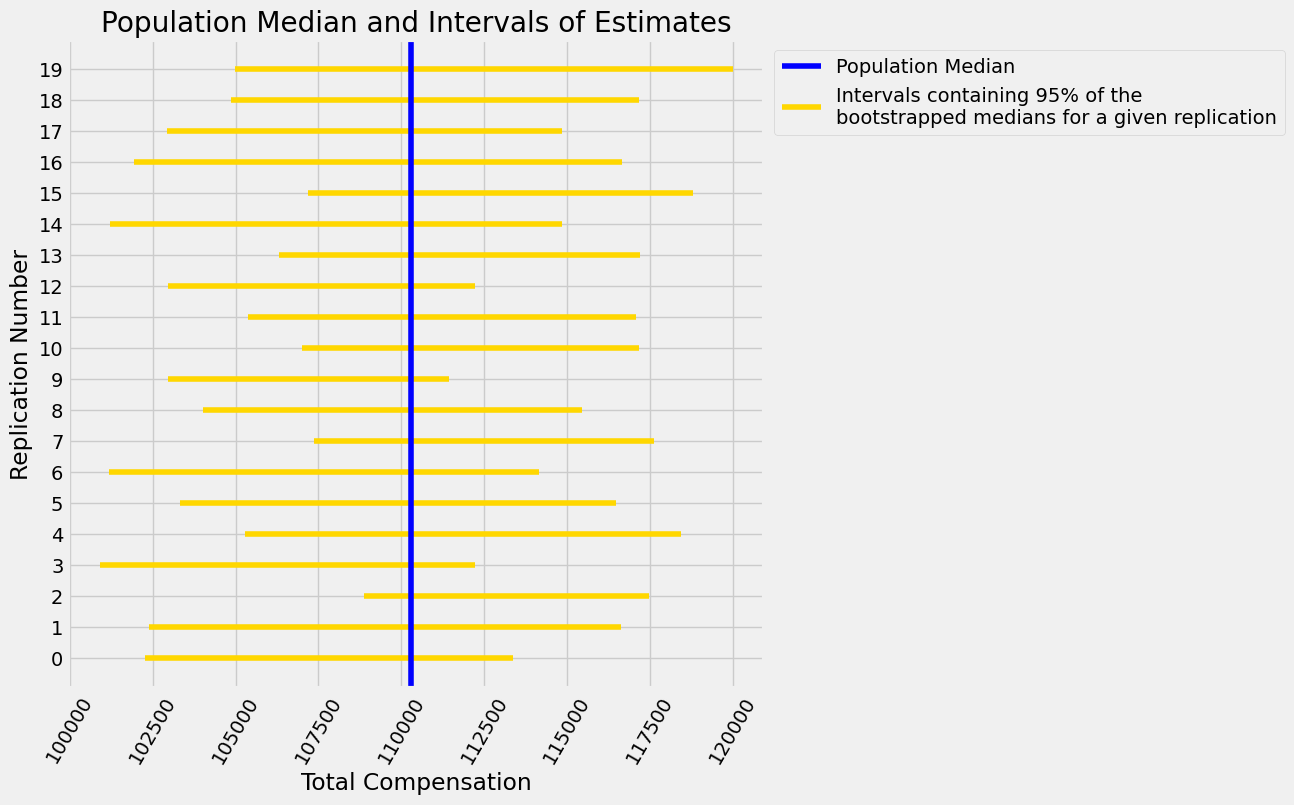

In [27]:
plt.figure(figsize=(8,8))
for i in np.arange(len(intervals)):
    ends = intervals[['Left', 'Right']].iloc[i]
    plt.plot(ends, [i, i], color='gold')
plt.axvline(pop_median,  color='blue', label = 'Population Median')
plt.plot([], [], color = 'gold',
         label = "Intervals containing 95% of the\nbootstrapped medians for a given replication")
plt.ylabel('Replication Number')
plt.yticks(np.arange(n_intervals))
plt.title('Population Median and Intervals of Estimates')
add_x_labels_total_compensation();

To summarize what the simulation shows, suppose you are estimating the
population median by the following process:

* Draw a large random sample from the population.
* Bootstrap your random sample and get an estimate from the new random sample.
* Repeat the above step thousands of times, and get thousands of estimates.
* Pick off the "middle 95%" interval of all the estimates.

That gives you one interval of estimates. Now if you repeat **the entire
process** 20 times, ending up with 20 intervals, then about 95% of those 20
intervals will contain the population parameter.

In other words, this process of estimation captures the parameter about 95% of
the time.

You can replace 95% by a different value, as long as it's not 100. Suppose you
replace 95% by 80% and keep the sample size fixed at 500. Then your intervals
of estimates will be shorter than those we simulated here, because the "middle
80%" is a smaller range than the "middle 95%". Only about 80% of your intervals
will contain the parameter.

# Back to The Fundamental Problem of Data Science

Remember our data scientists predicament? 

[common misinterpretations - the confidence level refers to the *method* of constructing
the intervals, but is commonly misinterpretted as referring to the the interval itself]

[You can use interval as a *guide* to where the population parameter may be - it is incorrect to
state that there is a 95% chance that the population parameter]

[If we were to repeat the sampling process multiple times and construct 95% confidence intervals from each sample, we would expect that approximately 95% of those intervals would contain the true population parameter.]

*Note*: This page has content from the [Bootstrap](https://github.com/data-8/textbook/blob/64b20f0/notebooks/Bootstrap.ipynb)
notebook of an older version of the [UC Berkeley data science course](https://inferentialthinking.com/). See the Berkeley course section of the [license file](https://uob-ds.github.io/cfd2021/license).